# Computing collision probabilities with ETTs

In this tutorial, we introduce an efficient method for computing the probability of collision during a close encounter (i.e., a conjunction) between two Earth-orbiting satellites. We assume that the nominal state at the time of closest approach (TCA), together with its associated uncertainty, is known. In operational contexts, this information is typically provided in the form of a [conjunction data message (CDM)](https://ccsds.org/publications/bluebooks/entry/3064/).

The collision probability is estimated using a Monte Carlo from TCA approach, but with a key difference from conventional implementations. Instead of numerically propagating each sampled initial condition to the time of closest approach, we exploit variational equations to construct an event-transition tensor (ETT) using a *single* numerical propagation. This tensor defines a Taylor map that directly relates the initial state uncertainty to the state on the event manifold. As a result, expensive orbit propagations and repeated relative distance/velocity checks are replaced by fast power-series evaluations, enabling a significant reduction in computational cost while preserving accuracy.

## Theoretical background

We begin by recalling and extending a few ideas first laid out in the [event sensitivity tutorial](./ev_sensitivity.ipynb). Our objective in this section is to establish how to compute the derivatives of the trigger time of an [event](<./Event detection.ipynb>) with respect to the initial conditions in an ODE system.

Without loss of generality, let us define an autonomous ODE system in two state variables $x$ and $y$ (the extension to an arbitrary number of variables and/or nonautonomous systems is straightforward, albeit notationally heavy): 

$$
\begin{cases}
\frac{dx}{dt} & = f\left(x,y\right)\\
\frac{dy}{dt} & = g\left(x,y\right)
\end{cases}.
$$

The solution of this system for a generic set of initial conditions $\left( x_0, y_0, t_0 \right)$ (i.e., the flow) is:

$$
\begin{cases}
x & = x \left( x_0, y_0, t_0, t\right) \\
y & = y \left( x_0, y_0, t_0, t\right)
\end{cases}.
$$ (flow)

We now introduce an [event function](<./Event detection.ipynb>) $h=h\left( x, y \right)$ and the corresponding event equation

$$
h\left( x, y \right)=0.
$$ (ev_eq)

```{note}

In the specific case of the computation of the collision probability, the event function we need to consider is

$$
   h\left( \boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{v}_1,\boldsymbol{v}_2 \right) = \left( \boldsymbol{r}_1 - \boldsymbol{r}_2 \right) \cdot \left( \boldsymbol{v}_1 - \boldsymbol{v}_2 \right),
$$

where $\boldsymbol{r}_i$ and $\boldsymbol{v}_i$ are the Cartesian positions and velocities of the two satellites. This is a stationarity condition: $h$ will be zero when the relative distance between the two satellites has reached a minimum/maximum value.

```

By substituting the flow {eq}`flow` into eq. {eq}`ev_eq`, we can rewrite the event equation in terms of the initial conditions:

$$
h\left( x_0, y_0, t_0, t \right)=0.
$$ (ev_eq_2)

We now assume that the event equation can be inverted to yield $t$ (i.e., the event *trigger time*) as a function of $x_0$, $y_0$ and $t_0$:

$$
t=t\left( x_0, y_0, t_0\right).
$$

By substituting this expression for the trigger time back into the event equation {eq}`ev_eq_2` we obtain:

$$
h\left( x_0, y_0, t_0, t\left( x_0, y_0, t_0\right) \right)=0.
$$ (ev_eq_3)

We can now proceed to compute the derivatives of eq. {eq}`ev_eq_3` wrt $x_0$ and $y_0$:

$$
\begin{cases}
\frac{\partial h}{\partial x_0} + \frac{\partial h}{\partial t}\frac{\partial t}{\partial x_0} & = 0 \\
\frac{\partial h}{\partial y_0} + \frac{\partial h}{\partial t}\frac{\partial t}{\partial y_0} & = 0
\end{cases}.
$$

We can then re-arrange to obtain the expressions for the derivatives of the trigger time wrt $x_0$ and $y_0$:

$$
\begin{cases}
\frac{\partial t}{\partial x_0} & = -\frac{\frac{\partial h}{\partial x_0}}{\frac{\partial h}{\partial t}} \\
\frac{\partial t}{\partial y_0} & = -\frac{\frac{\partial h}{\partial y_0}}{\frac{\partial h}{\partial t}}
\end{cases}.
$$ (te_sens)

These are nothing but the formulae for [implicit differentiation](https://en.wikipedia.org/wiki/Implicit_function#Implicit_differentiation). Note the singularity (pole) when $\frac{\partial h}{\partial t}=0$. Geometrically, this occurs when the state trajectory is tangent to the event manifold - often referred to as a *grazing* trajectory. In this regime, the trigger time becomes infinitely sensitive to the initial conditions. Physically, if the event function has a zero of multiplicity higher than 1, it represents a critical boundary: a small variation in initial conditions may cause the trajectory to miss the event manifold entirely, meaning the event no longer triggers.

$\frac{\partial h}{\partial x_0}$ and $\frac{\partial h}{\partial y_0}$ can be computed from eq. {eq}`ev_eq` via the chain rule, e.g.:

$$
\frac{\partial h}{\partial x_0} = \frac{\partial h}{\partial x}\frac{\partial x}{\partial x_0} + \frac{\partial h}{\partial y}\frac{\partial y}{\partial x_0}.
$$ (grad_h)

$\frac{\partial x}{\partial x_0}$ and $\frac{\partial y}{\partial x_0}$ are [variational state variables](./var_ode_sys.ipynb), encoding the sensitivity of the ODE system to variations in the initial conditions.

Regarding $\frac{\partial h}{\partial t}$, despite the use of the "$\partial$" symbol, this is actually the *total* derivative of $h$ wrt time, $\frac{dh}{dt}$ - the partial derivative symbol has been used in the derivation above because we have been considering $t$ as function of the initial conditions $x_0$, $y_0$ and $t_0$. $\frac{dh}{dt}$ is also easily computed via the chain rule:

$$
\frac{dh}{dt} = \frac{\partial h}{\partial x}\frac{dx}{dt} + \frac{\partial h}{\partial y}\frac{dy}{dt} = \frac{\partial h}{\partial x}f\left( x, y \right) + \frac{\partial h}{\partial y}g\left( x, y \right).
$$ (dh_dt)

Note how $\frac{dh}{dt}$ depends on the dynamics of the ODE system via $f\left( x, y \right)$ and $g\left( x, y \right)$.

We have thus established explicit formulae for the partial derivatives of the event trigger time $\frac{\partial t}{\partial x_0}$ and $\frac{\partial t}{\partial y_0}$ in terms of the state variables $x$ and $y$ and the variational state variables $\frac{\partial x}{\partial x_0}$, $\frac{\partial x}{\partial y_0}$, $\frac{\partial y}{\partial x_0}$ and $\frac{\partial y}{\partial y_0}$. We can use these partial derivatives to compute how the event trigger time changes under small variations $\Delta x_0$ and $\Delta y_0$ of the initial conditions:

$$
\Delta t \simeq \frac{\partial t}{\partial x_0}\Delta x_0 + \frac{\partial t}{\partial y_0} \Delta y_0.
$$

Although the derivation can be extended to higher-order derivatives, we will be limiting ourselves to first-order derivatives in this tutorial.

## The conjunction event

We can now proceed to apply the theoretical apparatus developed in the previous section to the specific problem of computing the collision probability.

To begin with, we need to introduce a dynamical model for the motion of the satellites during the conjunction event. In order to keep things simple, we will be assuming that the satellites are following purely-Keplerian orbits. For a higher-fidelity analysis, we could incorporate several additional dynamical effects such as the geopotential, atmospheric drag, third-body perturbations and so on.

The ODE system describing the Keplerian motion of the satellites reads:

$$
\begin{cases}
\frac{d\boldsymbol{r}_1}{dt} & = \boldsymbol{v}_1 \\
\frac{d\boldsymbol{v}_1}{dt} & = -\frac{\mu\boldsymbol{r}_1}{r_1^{\frac{3}{2}}} \\
\frac{d\boldsymbol{r}_2}{dt} & = \boldsymbol{v}_2 \\
\frac{d\boldsymbol{v}_2}{dt} & = -\frac{\mu\boldsymbol{r}_2}{r_2^{\frac{3}{2}}}
\end{cases},
$$ (dynamics)

where $\left( \boldsymbol{r}_1, \boldsymbol{v}_1, \boldsymbol{r}_2, \boldsymbol{v}_2 \right)$ is the Cartesian state of the two satellites and $\mu$ is the Earth's gravitational parameter. As mentioned in the introduction, we are assuming that the nominal initial conditions $\left( \boldsymbol{r}_{1,0}, \boldsymbol{v}_{1,0}, \boldsymbol{r}_{2,0}, \boldsymbol{v}_{2,0} \right)$ for this ODE correspond to a conjunction event: the mutual distance between the satellites has reached a minimum and $t=0$ corresponds to the event trigger time, that is, the time of closest approach (TCA). The event equation encoding the conjunction condition is:

$$
h\left( \boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{v}_1,\boldsymbol{v}_2 \right) = \left( \boldsymbol{r}_1 - \boldsymbol{r}_2 \right) \cdot \left( \boldsymbol{v}_1 - \boldsymbol{v}_2 \right) = 0.
$$ (ev_conj)

We can now proceed to the computation of the sensitivities of the event trigger time (which we will rename here $t_e$ in order to avoid confusion with the time variable $t$) via eqs. {eq}`te_sens`:

$$
\begin{cases}
\frac{\partial t_e}{\partial \boldsymbol{r}_{1,0}} & = - \frac{\frac{\partial h}{\partial \boldsymbol{r}_{1,0}}}{\frac{dh}{dt}}\\
\frac{\partial t_e}{\partial \boldsymbol{v}_{1,0}} & = - \frac{\frac{\partial h}{\partial \boldsymbol{v}_{1,0}}}{\frac{dh}{dt}}\\
\frac{\partial t_e}{\partial \boldsymbol{r}_{2,0}} & = - \frac{\frac{\partial h}{\partial \boldsymbol{r}_{2,0}}}{\frac{dh}{dt}}\\
\frac{\partial t_e}{\partial \boldsymbol{v}_{2,0}} & = - \frac{\frac{\partial h}{\partial \boldsymbol{v}_{2,0}}}{\frac{dh}{dt}}
\end{cases}.
$$ (te_sens_cj)

Compared to the [event sensitivity](./ev_sensitivity.ipynb) and [map inversion](./map_inversion.ipynb) tutorials, here we have an important simplification. The initial conditions of the ODE system are already satisfying by construction the event equation (i.e., the state of the system is already lying on the event manifold), thus the values of the variational state variables are particularly simple. Specifically, the only nonzero variational state variables are

$$
\begin{cases}
\frac{\partial\boldsymbol{r}_1}{\partial\boldsymbol{r}_{1,0}} &= I_3 \\
\frac{\partial\boldsymbol{v}_1}{\partial\boldsymbol{v}_{1,0}} &= I_3 \\
\frac{\partial\boldsymbol{r}_2}{\partial\boldsymbol{r}_{2,0}} &= I_3 \\
\frac{\partial\boldsymbol{v}_2}{\partial\boldsymbol{v}_{2,0}} &= I_3
\end{cases}
$$

(where we have indicated with $I_3$ the $3 \times 3$ identity matrix). Thanks to this simplification, the derivatives of the event function with respect to the initial conditions become, via eq. {eq}`grad_h`,

$$
\begin{cases}
\frac{\partial h}{\partial \boldsymbol{r}_{1,0}} & = \frac{\partial h}{\partial \boldsymbol{r}_1} \\
\frac{\partial h}{\partial \boldsymbol{v}_{1,0}} & = \frac{\partial h}{\partial \boldsymbol{v}_1} \\
\frac{\partial h}{\partial \boldsymbol{r}_{2,0}} & = \frac{\partial h}{\partial \boldsymbol{r}_2} \\
\frac{\partial h}{\partial \boldsymbol{v}_{2,0}} & = \frac{\partial h}{\partial \boldsymbol{v}_2}
\end{cases}.
$$ (grad_h_simpl)

We can now proceed to implement the computation of the sensitivities of $t_e$ using heyoka.py's expression system. We begin with the definition of the dynamics:

In [1]:
import heyoka as hy

# Introduce the state variables for the two satellites.
x1, y1, z1, vx1, vy1, vz1 = hy.make_vars("x1", "y1", "z1", "vx1", "vy1", "vz1")
x2, y2, z2, vx2, vy2, vz2 = hy.make_vars("x2", "y2", "z2", "vx2", "vy2", "vz2")
state_vars = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2]

# The Earth's gravitational parameter (in km**3/s**2).
mu_earth = 3.986004415e14 / 1e9

# Implement Keplerian dynamics.
r1_32 = hy.sum([x1**2, y1**2, z1**2]) ** -1.5
r2_32 = hy.sum([x2**2, y2**2, z2**2]) ** -1.5
dyn = [
    (x1, vx1),
    (y1, vy1),
    (z1, vz1),
    (vx1, -mu_earth * x1 * r1_32),
    (vy1, -mu_earth * y1 * r1_32),
    (vz1, -mu_earth * z1 * r1_32),
    (x2, vx2),
    (y2, vy2),
    (z2, vz2),
    (vx2, -mu_earth * x2 * r2_32),
    (vy2, -mu_earth * y2 * r2_32),
    (vz2, -mu_earth * z2 * r2_32),
]

```{note}

We will be using kilometres and seconds as units of distance and time.
```

Next, we introduce the event function $h$:

In [2]:
h_func = hy.sum(
    [(x1 - x2) * (vx1 - vx2), (y1 - y2) * (vy1 - vy2), (z1 - z2) * (vz1 - vz2)]
)

Its gradient with respect to the initial conditions (see eq. {eq}`grad_h_simpl`) is easily computed via {py:func}`~heyoka.diff_tensors()`:

In [3]:
h_grad = hy.diff_tensors([h_func], state_vars).gradient

The time derivative of the event function is also easily computed via eq. {eq}`dh_dt`:

In [4]:
import numpy as np

dh_dt = np.dot(h_grad, [dyn_fun for _, dyn_fun in dyn])

We can now compute the sensitivities of $t_e$ via eq. {eq}`te_sens_cj`, and package them into a [compiled function](./compiled_functions.ipynb) for evaluation:

In [5]:
grad_te_cf = hy.cfunc(-np.array(h_grad) / dh_dt, state_vars)

We have thus constructed a function that takes in input two Cartesian states satisfying the event equation {eq}`ev_conj`, and returns the first-order sensitivity of the event trigger time with respect to variations in the Cartesian states. In the Monte Carlo simulation, we will be using these sensitivities to compute how the event trigger time changes under small variations of the initial conditions:

$$
\Delta t_e \simeq \frac{\partial t_e}{\partial \boldsymbol{r}_{1,0}}\Delta \boldsymbol{r}_{1,0} +
\frac{\partial t_e}{\partial \boldsymbol{v}_{1,0}}\Delta \boldsymbol{v}_{1,0} +
\frac{\partial t_e}{\partial \boldsymbol{r}_{2,0}}\Delta \boldsymbol{r}_{2,0} +
\frac{\partial t_e}{\partial \boldsymbol{v}_{2,0}}\Delta \boldsymbol{v}_{2,0}.
$$ (Delta_t_e)

Note that in the Monte Carlo simulation, the ``grad_te_cf`` function needs to be evaluated only once.

## Input data

We will be using data derived from a conjunction detected by the [SOCRATES](https://celestrak.org/SOCRATES/) service in December 2025. The trajectories are described by the following [TLEs](https://en.wikipedia.org/wiki/Two-line_element_set):

In [6]:
s1 = "1 61904U 24205L   25354.90963950  .00008372  00000+0  38791-3 0  9993"
t1 = "2 61904  97.4350  65.3003 0028818 296.4783  63.3497 15.19966459 61254"

s2 = "1 62945U 97012R   25354.92518804  .00012562  00000+0  12934-2 0  9997"
t2 = "2 62945  98.3678  55.6216 0184755 142.6821 218.7391 14.78556977485038"

The UTC timestamp of the time of closest approach (TCA) is ``2025-12-25 04:57:05.881400103211``. Let us verify via the [SGP4 propagator](https://en.wikipedia.org/wiki/Simplified_perturbations_models) that indeed the conjunction takes place.

First, we compute the states of the satellites at TCA:

In [7]:
from sgp4.api import Satrec
from astropy.time import Time

# Parse the TLEs.
sat1 = satellite = Satrec.twoline2rv(s1, t1)
sat2 = satellite = Satrec.twoline2rv(s2, t2)

# Transform the TCA into a UTC Julian date.
conj_tm = Time(val="2025-12-25 04:57:05.881400103211", format="iso", scale="utc")

# Compute the states of the satellites at TCA.
_, r1, v1 = sat1.sgp4(conj_tm.jd1, conj_tm.jd2)
_, r2, v2 = sat2.sgp4(conj_tm.jd1, conj_tm.jd2)

Now we can verify numerically that indeed the event function $h\left( \boldsymbol{r}_1,\boldsymbol{r}_2,\boldsymbol{v}_1,\boldsymbol{v}_2 \right)$ is (close to) zero at TCA:

In [8]:
print(f"Value of h at TCA: {np.dot(np.array(r1) - r2, np.array(v1) - v2)}")

Value of h at TCA: 2.6241552333883256e-11


Indeed, the conjunction condition is satisfied to a high degree of accuracy.

What about the orbital characteristics of this conjunction? Let us examine the orbital radius:

In [9]:
print(f"Orbital radius: {np.linalg.norm(r1)} km")

Orbital radius: 6896.224123030422 km


That is, we are in a low-Earth orbit. The relative velocity at conjunction is:

In [10]:
print(f"Relative velocity at conjunction: {np.linalg.norm(np.array(v1) - v2)} km/s")

Relative velocity at conjunction: 1.2560630698452764 km/s


This is a rather low-velocity encounter. Indeed, the data from the [SOCRATES](https://celestrak.org/SOCRATES/socrates-format.php) service indicate that only about 2% of conjunctions between Earth-orbiting spacecraft has a relative velocity of 1.2 km/s or less.

## Random sampling

We can now proceed to generate the random samples for the Monte Carlo simulation.

Because TLEs do not include covariance information, we adopt the same (simplified) assumptions used by [SOCRATES](https://celestrak.org/SOCRATES/socrates-format.php) regarding the state uncertainty at TCA. Specifically, we assume a Gaussian probability distribution for the positional uncertainty at TCA with 1-sigma standard deviations of 100m, 300m and 100m in the radial, in-track and cross-track directions respectively. In other words, the covariance matrix is assumed to be diagonal.

```{note}

In operational CDMs, covariance matrices will typically be non-diagonal and they may include velocity covariances as well. Here, we limit ourselves to uncorrelated positional uncertainties only.

```

```{note}

In heyoka.py, the radial, in-track and cross-track reference frame is known as RSW frame. Please see the documentation of {py:func}`~heyoka.model.state_to_rsw()` for details.

```

Let us generate the random positional samples for the two satellites in their RSW frames:

In [11]:
# Deterministic seeding.
rng = np.random.default_rng(420)

# Number of Monte Carlo samples.
N = 1_000_000

# 1-sigma position uncertainties in km (RSW frame).
sigma_R = 0.1
sigma_T = 0.3
sigma_N = 0.1

# Mean position at TCA (RSW frame).
mpos = np.zeros((3,))

# Cholesky factor of the covariance matrix (diagonal in this case).
L = np.diag([sigma_R, sigma_T, sigma_N])

# Draw standard normal samples.
z1 = rng.standard_normal((N, 3))
z2 = rng.standard_normal((N, 3))

# Transform to correlated samples.
samples1 = mpos + z1 @ L.T
samples2 = mpos + z2 @ L.T

The samples in the RSW frames must be transformed into an inertial (i.e., non-rotating) reference frame for the purpose of numerical propagation. Via the {py:func}`~heyoka.model.state_from_rsw()` function we can easily transform the samples to the reference frame used by the TLEs, which is called TEME (see also {py:func}`~heyoka.model.rot_itrs_teme()`). Although the TEME frame is not fully inertial, the timescale of its rotational evolution is much longer than the duration of a close encounter and thus it can be considered as inertial for the computation of the collision probability.

In [12]:
# Introduce a compiled function for the transformation from RSW to TEME.
pos_x, pos_y, pos_z, vel_x, vel_y, vel_z = hy.make_vars(
    "pos_x", "pos_y", "pos_z", "vel_x", "vel_y", "vel_z"
)
x, y, z, vx, vy, vz = hy.make_vars("x", "y", "z", "vx", "vy", "vz")
rsw_cf = hy.cfunc(
    hy.model.state_from_rsw(
        pos=[pos_x, pos_y, pos_z],
        vel=[vel_x, vel_y, vel_z],
        r=[x, y, z],
        v=[vx, vy, vz],
    )[0],
    [pos_x, pos_y, pos_z, x, y, z, vx, vy, vz],
)

# Transform the samples back to TEME.
samples1_teme = rsw_cf(
    np.vstack(
        (
            samples1.T,
            # NOTE: splat the position/velocity of the satellite.
            np.repeat(r1, N).reshape((3, -1)),
            np.repeat(v1, N).reshape((3, -1)),
        )
    )
)
samples2_teme = rsw_cf(
    np.vstack(
        (
            samples2.T,
            np.repeat(r2, N).reshape((3, -1)),
            np.repeat(v2, N).reshape((3, -1)),
        )
    )
)

In order to compute $\Delta t_e$ via eq. {eq}`Delta_t_e`, the positional random samples in the TEME frame must be transformed into differences wrt the initial satellite states:

In [13]:
delta1 = samples1_teme.T - r1
delta2 = samples2_teme.T - r2

It is convenient to package the positional differences together with the velocity differences (which, as explained earlier, are zero due to our assumptions about the covariance matrix):

In [14]:
deltas = np.hstack((delta1, np.zeros((N, 3)), delta2, np.zeros((N, 3))))

This allows us to easily compute the variations in event trigger time via {eq}`Delta_t_e`:

In [15]:
Delta_te = deltas @ grad_te_cf(list(r1) + list(v1) + list(r2) + list(v2))

Let us take a quick look at the magnitude of the variations:

In [16]:
np.max(np.abs(Delta_te))

np.float64(0.5726648596277499)

In other words, the largest variation in event trigger time is about half a second.

(ev_manifold_map)=
## Mapping perturbed states to the event manifold

After having established how the conjunction event trigger time reacts to changes in the initial conditions, the next step is to establish how the satellites' *states* at conjunction react to changes in the initial conditions. This can be accomplished through the use of a [variational Taylor integrator](./var_ode_sys.ipynb): we will first propagate the states of the satellites (and their derivatives with respect to the initial conditions) up to the new event trigger time, and we will then use the Taylor map evaluation feature in order to compute the new states at conjunction.

In order to avoid an expensive numerical propagation for each Monte Carlo sample, we will run instead a *single* propagation to generate the [dense output](<./Dense output.ipynb>) around the initial conditions. We will then use the dense output to propagate manually (via Taylor series evaluation) the state up to the new conjunction event trigger time.

Because we will be propagating the state of one satellite at a time, the variational integrator can be constructed using only the first half of the dynamical equations {eq}`dynamics`:

In [17]:
vsys = hy.var_ode_sys(dyn[:6], state_vars[:6])
ta_var = hy.taylor_adaptive(vsys, compact_mode=True, tol=1.0)

Note how we have set a very high tolerance of ``1.0``, which will result in a Taylor integrator of order 2 (the minimum possible order). Below, we will go even further, discarding the quadratic Taylor coefficients. As we will show later, even though we are studying a relatively low-velocity encounter, a linear solution is enough to accurately determine the state at the new conjunction time (which, as we have shown earlier, typically differs from the original conjunction time by fractions of a second). In extremely low-velocity encounters (e.g., during formation flying), we would need to retain the quadratic Taylor coefficients and possibly move to even higher orders. 

We can now proceed to generate the dense output for the two satellites around their initial conditions. We achieve this by first passing the ``write_tc=True`` argument to the ``step()`` method and then fetching the Taylor coefficients of the solution via the ``tc`` property:

In [18]:
# Generate the dense output for the first satellite.
ta_var.state[0:3] = r1
ta_var.state[3:6] = v1
ta_var.state[6:] = np.identity(6).flatten()
ta_var.step(write_tc=True, max_delta_t=0.0)
# NOTE: discard the quadratic Taylor coefficients.
tc1 = np.copy(ta_var.tc[:, :2])

# Generate the dense output for the second satellite.
ta_var.state[0:3] = r2
ta_var.state[3:6] = v2
ta_var.state[6:] = np.identity(6).flatten()
ta_var.step(write_tc=True, max_delta_t=0.0)
tc2 = np.copy(ta_var.tc[:, :2])

We then create NumPy polynomials for the evaluation of the dense output:

In [19]:
tc_polys1 = [np.polynomial.polynomial.Polynomial(_) for _ in tc1]
tc_polys2 = [np.polynomial.polynomial.Polynomial(_) for _ in tc2]

We can now proceed to select a random sample (e.g., the first one) and propagate the original states to the new event:

In [20]:
# Pick the first random sample.
delta_idx = 0

# Propagate the state of the first satellite to the new event trigger time
# via Taylor series evaluation.
prop_state1 = np.array([poly(Delta_te[delta_idx]) for poly in tc_polys1])
# Manually assign the propagated state to the integrator object.
ta_var.state[:] = prop_state1
# Use eval_taylor_map() to compute the state at the new event, given a set
# of variations in the initial conditions.
st1 = np.copy(ta_var.eval_taylor_map(deltas[delta_idx][:6]))

# Do the same for the second satellite.
prop_state2 = np.array([poly(Delta_te[delta_idx]) for poly in tc_polys2])
ta_var.state[:] = prop_state2
st2 = np.copy(ta_var.eval_taylor_map(deltas[delta_idx][6:]))

We are now ready to check the value of the event function:

In [21]:
np.dot(st1[:3] - st2[:3], st1[3:6] - st2[3:6])

np.float64(4.6620082503646965e-09)

We can see how the event function is fairly close to zero.

In order to provide a better quantitative assessment, let us run a standard numerical integration with conjunction detection. First we create an integrator to propagate the state of both satellites, with a [terminal event](<./Event detection.ipynb>) that stops the integration at conjunction:

In [22]:
ta = hy.taylor_adaptive(
    dyn, state=list(r1) + list(v1) + list(r2) + list(v2), t_events=[hy.t_event(h_func)]
)

Second, we perturb the initial state of the system with the random samples:

In [23]:
ta.state[:] = ta.state + deltas[delta_idx]

Finally, we propagate the system for a very large time - the integration should be stopped almost immediately by the triggering of the conjunction event. The direction in time of the propagation (forward or backward) can be determined by the sign of ``Delta_te[delta_idx]``:

In [24]:
ta.propagate_until(1e9 if Delta_te[delta_idx] >= 0 else -1e9)

(<taylor_outcome.???: -1>, inf, 0.0, 1, None, None)

We are now ready to compare this "exact" result with our approximated approach.

First, let us take a look at the time of closest approach (TCA):

In [25]:
print(f"Difference in TCA: {ta.time - Delta_te[delta_idx]} s")

Difference in TCA: -2.904672904979755e-09 s


We can see that the TCAs agree at the nanosecond level.

Let us also take a look at the difference in distance of closest approach (DCA). This is the most important metric when assessing the viability of our approach, as this quantity determines whether or not a collision between the satellites takes place:

In [26]:
print(
    f"Difference in DCA: {np.linalg.norm(ta.state[:3] - ta.state[6:9]) - np.linalg.norm(st1[:3] - st2[:3])} km"
)

Difference in DCA: -3.082498700734959e-10 km


We can see that the agreement is well below the millimetre level. 

## Speeding up with JIT compilation

In the previous section we have outlined an initial, pedagogical implementation of our approach for mapping perturbations in the initial state to the event manifold. In this section, our objective is to speed up the implementation via the use of [compiled functions](./compiled_functions.ipynb).

We will need a compiled function that takes in input:

- a set of 6 perturbations to the state of a satellite and the corresponding variation of the event trigger time,
- the dense output of the variational integrator.

The output of the compiled function is the state of the spacecraft on the perturbed event manifold.

Let us begin with the introduction of the symbolic variables representing the Taylor coefficients of the dense output:

In [27]:
t_cfs = []

# Names of the state variables.
var_names = ["x", "y", "z", "vx", "vy", "vz"]

# Create the Taylor coefficients for the state variables.
for name in var_names:
    t_cfs += [hy.expression(f"cf_{name}_{i}") for i in range(2)]

# Create the Taylor coefficients for the variational state variables.
for name1 in var_names:
    for name2 in var_names:
        t_cfs += [hy.expression(f"cf_d{name1}_d{name2}0_{i}") for i in range(2)]

# Reshape into a 2D array for ease of access.
#
# NOTE: we have 42 sets of Taylor coefficients: 6 for the state variables
# and 6x6 for the variational state variables.
t_cfs = np.array(t_cfs).reshape((42, -1))

Next, we introduce the symbolic variable representing the variation of the event trigger time:

In [28]:
Dte = hy.expression("Delta_te")

We now need a function to evaluate the dense output for each state variable (including the variational ones). We can use [Horner's method](https://en.wikipedia.org/wiki/Horner%27s_method) to evaluate the Taylor series of the dense output:

In [29]:
def horner_eval(cfs, x):
    order = len(cfs) - 1

    res = cfs[order]
    for i in range(1, order + 1):
        res = cfs[order - i] + (res * x)

    return res

We can then propagate the full state vector (including the variational variables) up to the new event trigger time:

In [30]:
pstate = [horner_eval(cfs, Dte) for cfs in t_cfs]

The last step is to use the variational state variables to map the perturbations to the initial conditions to the event manifold. This is accomplished through the evaluation of [multivariate Taylor series](https://en.wikipedia.org/wiki/Taylor_series#Taylor_series_in_several_variables). First we introduce symbolic variables representing the perturbations of the initial conditions:

In [31]:
ic_perts = hy.make_vars("Dx0", "Dy0", "Dz0", "Dvx0", "Dvy0", "Dvz0")

Then, we can perform the evaluation of the multivariate Taylor series. Note that we do not need to propagate the velocities to the event manifold, for the computation of the collision probability propagating the positions is enough:

In [32]:
# Isolate the variational state variables in a 2D array for ease of access.
pstate_v = np.array(pstate[6:]).reshape((6, 6))

# Compute the positions on the event manifold.
new_pos = [hy.sum([pstate[idx]] + list(pstate_v[idx] * ic_perts)) for idx in range(3)]

Finally, we can package ``new_pos`` into a compiled function for fast evaluation: 

In [33]:
new_pos_cf = hy.cfunc(new_pos, ic_perts + [Dte] + list(t_cfs.flatten()))

In order to fully realise the performance potential of compiled functions, we can {ref}`batch <cf_batch>` the computation over *all* random samples by stacking the ``deltas``, ``Delta_te`` and Taylor coefficients arrays (which need to be splatted over the ``N`` samples):

In [34]:
batch_input1 = np.vstack(
    (deltas[:, :6].T, Delta_te.T, np.repeat(tc1.flatten(), N).reshape((-1, N)))
)
batch_input2 = np.vstack(
    (deltas[:, 6:].T, Delta_te.T, np.repeat(tc2.flatten(), N).reshape((-1, N)))
)

## Running the Monte Carlo simulation

We can now proceed to actually running the Monte Carlo simulation. The first step is to evaluate the states of the two satellites on the perturbed event manifolds:

In [35]:
%%time
# NOTE: use batch_parallel=False to force single-core execution.
new_pos1 = new_pos_cf(batch_input1, batch_parallel=False)
new_pos2 = new_pos_cf(batch_input2, batch_parallel=False)

CPU times: user 36.2 ms, sys: 5.01 ms, total: 41.2 ms
Wall time: 40.8 ms


We can see that we were able to run $10^6$ evaluations for each satellite in ~40ms on a single core.

We can now compute the collision probability by counting how many times the distance between the two satellites on the perturbed event manifolds is less than the combined spherical body radius of the two satellites. We arbitrarily pick a spherical body radius of 1 metre for each satellite, so that the combined radius is 2 metres:

In [36]:
n_collisions = np.count_nonzero(np.linalg.norm(new_pos1 - new_pos2, axis=0) < 2e-3)

print(f"Total number of collisions: {n_collisions}")
print(f"Collision probability     : {n_collisions / N}")

Total number of collisions: 28
Collision probability     : 2.8e-05


The collision probability is around $3\cdot 10^{-5}$, thus slightly below the commonly-used threshold of $10^{-4}$ that would warrant a collision avoidance maneuver.

Let us visualise the positions of the satellites on the perturbed event manifolds:

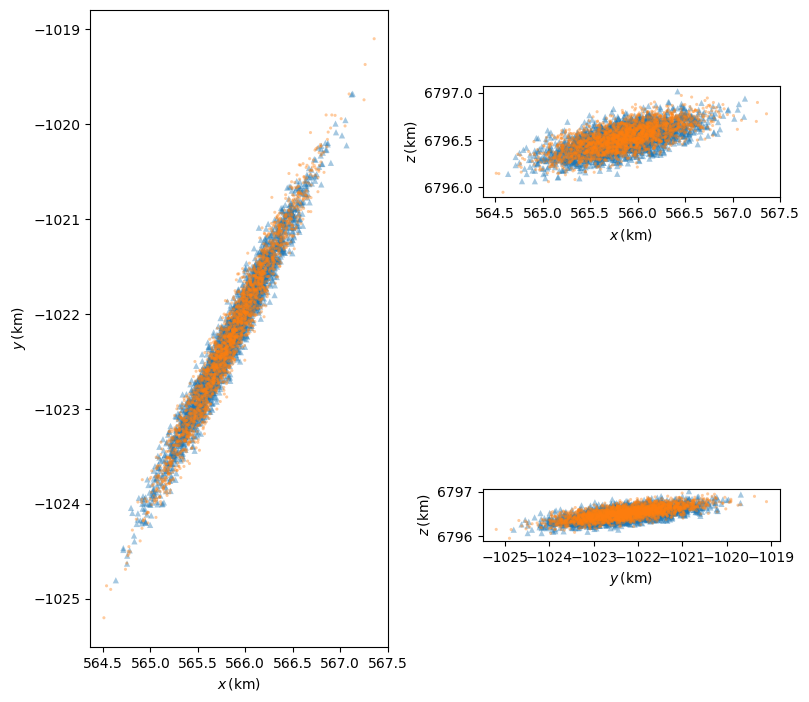

In [37]:
%matplotlib inline

from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 8))

alpha = 0.4
sz = 20

ax = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax.scatter(
    new_pos2[0, ::400],
    new_pos2[1, ::400],
    s=sz,
    alpha=alpha,
    marker="^",
    edgecolors="none",
)
ax.scatter(
    new_pos1[0, ::400],
    new_pos1[1, ::400],
    s=sz,
    alpha=alpha,
    marker=".",
    edgecolors="none",
)
ax.set_xlabel(r"$x\,\left(\mathrm{km}\right)$")
ax.set_ylabel(r"$y\,\left(\mathrm{km}\right)$")
ax.set_aspect("equal")

ax = plt.subplot2grid((2, 2), (0, 1))
ax.scatter(
    new_pos2[0, ::400],
    new_pos2[2, ::400],
    s=sz,
    alpha=alpha,
    marker="^",
    edgecolors="none",
)
ax.scatter(
    new_pos1[0, ::400],
    new_pos1[2, ::400],
    s=sz,
    alpha=alpha,
    marker=".",
    edgecolors="none",
)
ax.set_xlabel(r"$x\,\left(\mathrm{km}\right)$")
ax.set_ylabel(r"$z\,\left(\mathrm{km}\right)$")
ax.set_aspect("equal")

ax = plt.subplot2grid((2, 2), (1, 1))
ax.scatter(
    new_pos2[1, ::400],
    new_pos2[2, ::400],
    s=sz,
    alpha=alpha,
    marker="^",
    edgecolors="none",
)
ax.scatter(
    new_pos1[1, ::400],
    new_pos1[2, ::400],
    s=sz,
    alpha=alpha,
    marker=".",
    edgecolors="none",
)
ax.set_xlabel(r"$y\,\left(\mathrm{km}\right)$")
ax.set_ylabel(r"$z\,\left(\mathrm{km}\right)$")
ax.set_aspect("equal")

plt.tight_layout();

## Validation

We are now ready to perform a more extensive quantiative validation of our approach. We will be following the same methodology introduced in a {ref}`previous section <ev_manifold_map>` - specifically, we will compare the projected positions on the event manifold ``new_pos1`` and ``new_pos2`` to a full numerical propagation with event detection. In order to speed up the comparison, we will be using the [ensemble propagations](./ensemble_mode.ipynb) feature.

As a first step, we randomly choose 10000 displacements:

In [38]:
rnd_idx = rng.choice(np.arange(Delta_te.size), 10000, replace=False)

We limit the comparison to 10000 samples because checking all $10^6$ samples would take too long, even while using ensemble propagations.

We then split the samples into two sets. The first set contains the samples which result in a perturbed TCA *after* the original TCA, the second set contains the samples which result in a perturbed TCA *before* the original TCA. We need to do this because the ensemble propagation API does not allow to mix propagations forward and backward in time:

In [39]:
rnd_idx_pos = rnd_idx[np.nonzero(Delta_te[rnd_idx] >= 0)[0]]
rnd_idx_neg = rnd_idx[np.nonzero(Delta_te[rnd_idx] < 0)[0]]

We can then proceed to the definition of the generator for the ensemble propagations:

In [40]:
class gen:
    def __init__(self, rnd_idx):
        self._rnd_idx = rnd_idx

    def __call__(self, ta_copy, idx):
        ta_copy.reset_cooldowns()
        ta_copy.time = 0.0
        dlt = deltas[self._rnd_idx[idx]]
        ta_copy.state[:3] = r1 + dlt[:3]
        ta_copy.state[3:6] = v1 + dlt[3:6]
        ta_copy.state[6:9] = r2 + dlt[6:9]
        ta_copy.state[9:12] = v2 + dlt[9:12]

        return ta_copy

The generator is tasked with setting up the numerical propagation with the initial perturbed states.

We can now proceed to running the ensemble propagations:

In [41]:
# Propagation forward in time.
ret_pos = hy.ensemble_propagate_until(ta, 1e9, len(rnd_idx_pos), gen(rnd_idx_pos))
# Propagation backward in time.
ret_neg = hy.ensemble_propagate_until(ta, -1e9, len(rnd_idx_neg), gen(rnd_idx_neg))

We can now compute the distances of closest approach (DCAs) according to the high-precision numerical propagations:

In [42]:
dca_pos = [np.linalg.norm(_[0].state[:3] - _[0].state[6:9]) for _ in ret_pos]
dca_neg = [np.linalg.norm(_[0].state[:3] - _[0].state[6:9]) for _ in ret_neg]

Finally, we can compute the DCA differences with respect to the fast method:

In [43]:
dca_diff_pos = dca_pos - np.linalg.norm((new_pos1 - new_pos2).T[rnd_idx_pos], axis=1)
dca_diff_neg = dca_neg - np.linalg.norm((new_pos1 - new_pos2).T[rnd_idx_neg], axis=1)
dca_diff = np.hstack((dca_diff_pos, dca_diff_neg))

Let us take a look at the mean and maximum DCA differences:

In [44]:
print(f"Mean DCA difference: {np.mean(np.abs(dca_diff)) * 1e3} m")
print(f"Max DCA difference : {np.max(np.abs(dca_diff)) * 1e3} m")

Mean DCA difference: 2.5714309293893047e-06 m
Max DCA difference : 0.00010532091843096225 m


We can see that, even in the worst-case scenario, the DCA difference remains well below the millimetre level.

In this low-velocity encounter, the largest source of accuracy loss is the linear approximation we chose to adopt for the dense output of the Taylor integrator. If we switch from a linear to a quadratic approximation (thus retaining the terms up to order 2 in the Taylor series of the dense output), the maximum DCA difference drops by two orders of magnitude to roughly $10^{-6}$ metres.

## Conclusions

In this tutorial, we have demonstrated how the Event-Transition Tensor (ETT) approach provides a high-performance alternative to traditional methods for satellite collision risk assessment. By utilizing variational equations to construct a Taylor map, we effectively replace millions of expensive numerical propagations with a single integration followed by rapid power-series evaluations. This results in a massive reduction in computational cost - evaluating one million samples in a fraction of the time required for standard Monte Carlo - while maintaining sub-millimetre accuracy in the determined distance of closest approach (DCA).

Crucially, the ETT method overcomes several fundamental limitations of classical analytical formulas (such as Foster's 2D approach). While analytical models often rely on the "high-velocity assumption" and 2D projections, the ETT framework is inherently robust to low-velocity encounters. Furthermore, the method naturally incorporates velocity covariances and is not restricted to Gaussian uncertainty distributions.